In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata
import scipy.stats as stats
import geopandas as gpd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 16})

In [2]:
def remove_outliers_IQR(data, limit):
    len_nan = len(data[np.isnan(data)])
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp))-len_nan, len(data.flatten())))
    return data_cp

In [3]:
# load the buoy data
buoy_swh = xr.open_dataset('GNSS_SWH_at_SWOT_times.nc')
buoy_loc = pd.read_csv('buoy_locations_FSP_latlon.csv')

# load the SWOT data
swot_swh = xr.open_dataset('SWOT_SWH_at_buoys.nc')


In [4]:
buoy_swh = buoy_swh.reindex(time=swot_swh.time.values, method='nearest', tolerance='1H')

In [5]:
resid_5km = swot_swh.swh_5km.values - buoy_swh.swh_40.values
resid_2km = swot_swh.swh_2km.values - buoy_swh.swh_40.values

In [6]:
resid_5km_clean = resid_5km.copy()
resid_2km_clean = resid_2km.copy()

for i in range(9):
    resid_5km_clean[i,:] = remove_outliers_IQR(resid_5km[i,:], 1.5)
    resid_2km_clean[i,:] = remove_outliers_IQR(resid_2km[i,:], 1.5)

buoy_swh['buoy_swh_clean'] = buoy_swh.swh_40.copy()
swot_swh['swh_2km_clean'] = swot_swh.swh_2km.copy()

for i in range(9):
    buoy_swh['buoy_swh_clean'][i,:][np.isnan(resid_2km_clean[i,:])] =  np.nan
    swot_swh['swh_2km'][i,:][np.isnan(resid_2km_clean[i,:])] =  np.nan

Removed 3 / 95 points
Removed 3 / 95 points
Removed 4 / 95 points
Removed 6 / 95 points
Removed 5 / 95 points
Removed 5 / 95 points
Removed 4 / 95 points
Removed 5 / 95 points
Removed 1 / 95 points
Removed 2 / 95 points
Removed 1 / 95 points
Removed 3 / 95 points
Removed 0 / 95 points
Removed 0 / 95 points
Removed 7 / 95 points
Removed 7 / 95 points
Removed 0 / 95 points
Removed 0 / 95 points


In [7]:
# print nmber of points removed

len(resid_2km[~np.isnan(resid_2km)]) - len(resid_2km_clean[~np.isnan(resid_2km_clean)])

31

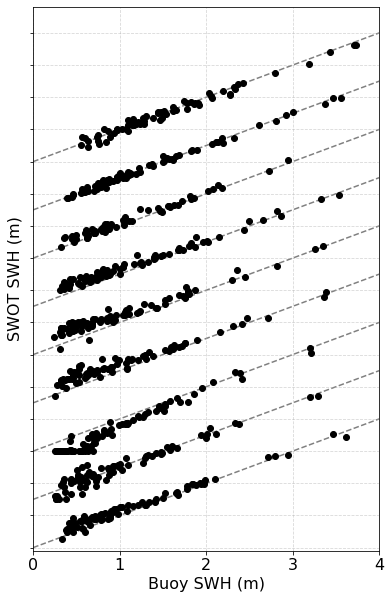

In [10]:
### plot comparisons for 2 km SWOT product

fig, ax = plt.subplots(1, figsize=(6.2, 10))
for i in range(9):
    offset = 12
    offset = offset-i*1.5
    ax.scatter(buoy_swh['buoy_swh_clean'][i], swot_swh['swh_2km'][i]+offset, marker='o', label=f'buoy {buoy_loc.ID[i]}', c='k', zorder=5)
    ax.plot([0, 4], [offset, offset+4], linestyle='--', c='grey', zorder=1)

ax.set_ylim(-0.1, 16.8)
ax.set_xlim(0, 4)
ax.set_xlabel('Buoy SWH (m)')
ax.set_ylabel('SWOT SWH (m)')
ax.set_yticklabels([])
ax.set_yticks(np.linspace(0,16,17))
ax.grid(linestyle='--', alpha=0.5)

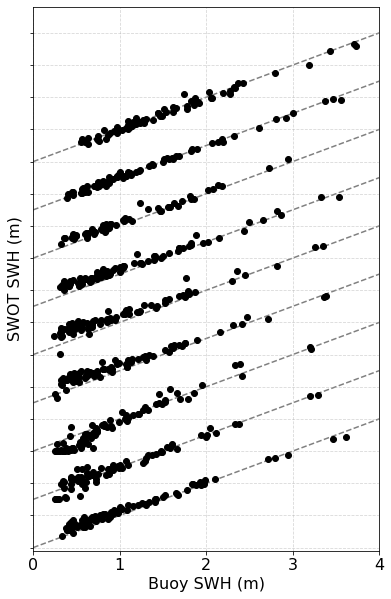

In [11]:
### repeat for 5 km

fig, ax = plt.subplots(1, figsize=(6.2, 10))
for i in range(9):
    offset = 12
    offset = offset-i*1.5
    ax.scatter(buoy_swh['buoy_swh_clean'][i], swot_swh['swh_5km'][i]+offset, marker='o', label=f'buoy {buoy_loc.ID[i]}', c='k', zorder=5)
    ax.plot([0, 4], [offset, offset+4], linestyle='--', c='grey', zorder=1)

ax.set_ylim(-0.1, 16.8)
ax.set_xlim(0, 4)
ax.set_xlabel('Buoy SWH (m)')
ax.set_ylabel('SWOT SWH (m)')
ax.set_yticklabels([])
ax.set_yticks(np.linspace(0,16,17))
ax.grid(linestyle='--', alpha=0.5)

In [12]:
resid_5km_clean_flat = resid_5km_clean.flatten()
resid_2km_clean_flat = resid_2km_clean.flatten()
buoy_swh_flat = buoy_swh.buoy_swh_clean.values.flatten()

print('Overall 5km stdev: %.2f m  RMSE: %.2f m  mean: %.2f m  n = %d' % (np.nanstd(resid_5km_clean_flat), np.sqrt(np.nanmean(resid_5km_clean_flat**2)), np.nanmean(resid_5km_clean_flat), len(resid_5km_clean_flat[~np.isnan(resid_5km_clean_flat)])))
print('Overall 2km stdev: %.2f m  RMSE: %.2f m  mean: %.2f m  n = %d' % (np.nanstd(resid_2km_clean_flat), np.sqrt(np.nanmean(resid_2km_clean_flat**2)), np.nanmean(resid_2km_clean_flat), len(resid_2km_clean_flat[~np.isnan(resid_2km_clean_flat)])))

resid_5km_clean_flat[buoy_swh_flat<1] = np.nan
resid_2km_clean_flat[buoy_swh_flat<1] = np.nan

print('')
print('high waves')
print('Overall 5km stdev: %.2f m  RMSE: %.2f m  mean: %.2f m  n = %d' % (np.nanstd(resid_5km_clean_flat), np.sqrt(np.nanmean(resid_5km_clean_flat**2)), np.nanmean(resid_5km_clean_flat), len(resid_5km_clean_flat[~np.isnan(resid_5km_clean_flat)])))
print('Overall 2km stdev: %.2f m  RMSE: %.2f m  mean: %.3f m  n = %d' % (np.nanstd(resid_2km_clean_flat), np.sqrt(np.nanmean(resid_2km_clean_flat**2)), np.nanmean(resid_2km_clean_flat), len(resid_2km_clean_flat[~np.isnan(resid_2km_clean_flat)])))

print('')
print()

Overall 5km stdev: 0.17 m  RMSE: 0.19 m  mean: 0.08 m  n = 670
Overall 2km stdev: 0.21 m  RMSE: 0.22 m  mean: 0.06 m  n = 683

high waves
Overall 5km stdev: 0.11 m  RMSE: 0.12 m  mean: 0.05 m  n = 305
Overall 2km stdev: 0.11 m  RMSE: 0.12 m  mean: 0.030 m  n = 308


